# DQMC Code following Tutorial

In [22]:
import numpy as np
import datetime,os
from scipy import linalg as la
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from itertools import product

np.set_printoptions(precision=6)
#%load_ext line_profiler
#%load_ext memory_profiler
%load_ext autoreload

import sys
sys.path.insert(0,"/home/katherine/Documents/GradWork/Devereaux/DQMC-Sync-SHERLOCK/edwin/dqmc/util")
import util #Edwin's util file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%autoreload 2

# MODEL: Hubbard (NN & NNN) on 2D lattice, periodic B.C. , zero spin domain S_z = (nup-ndn)/2 = 0, Assume up and down electrons behave the same way - no spin coupling Zeeman term

## Kinetic matrix

In [24]:
def makeKMatrix(Nx,Ny,t=1,tp=0,mu=0):
    '''Generate kinetic matrix for 2D square Nx-by-Ny lattice, periodic bdy conditions.
    Args:
        t = NN hopping strength
        tp = NNN hopping stength
        mu = Chemical potential
        Nx, Ny = Lattice dimensions
    Returns:
        A shape (N,N) float numpy array, N = Nx*Ny. 
        Matrix created is deliberately not sparse. '''

    # Initialize vectors of row and column indices, matrix data
    i,j = np.empty(0,dtype=int), np.empty(0,dtype=int)
    data = np.empty(0,dtype=float);
    
    #Look at each lattice pt, find nearest neighbors
    for y in range(Ny):
        for x in range(Nx):
            #total index n
            n = x + Nx*y;
            #neighbors, with periodic B.C.
            neighbors = [((x+1) % Nx,y),((x-1) % Nx,y),(x,(y+1) % Ny),(x,(y-1) % Ny)]
            next_neighbors = [((x+1) % Nx,(y+1) % Ny),((x-1) % Nx,(y+1) % Ny),
                              ((x+1) % Nx,(y-1) % Ny),((x-1) % Nx,(y-1) % Ny)]
            #get total indices of nearest neighbors
            for pt in neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-t)*np.ones(len(neighbors),dtype=float))
            #get total indices of next-nearest neighbors
            for pt in next_neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-tp)*np.ones(len(next_neighbors),dtype=float))
            #everything stays in n-th column
            j = np.append(j,n*np.ones(len(neighbors)+len(next_neighbors),dtype=int))
            
            #chemical potential contribes only to diagonal elements
            i = np.append(i,n);
            j = np.append(j,n);
            data = np.append(data,-mu)
    
    #Construction
    kmatrix = coo_matrix((data, (i,j)),shape = (Nx*Ny,Nx*Ny)).toarray()
    return kmatrix

kinetic matrix with phase output datatype: float64


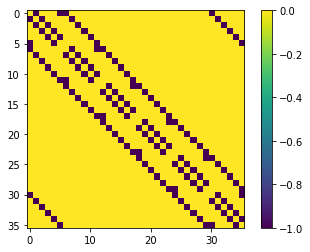

In [25]:
kay = makeKMatrix(6,6,t=1,tp = 0,mu=0);
print('kinetic matrix with phase output datatype:',kay.dtype)
plt.imshow(kay);plt.colorbar();

## ADD PEIERL's PHASE TO KINETIC MATRIX
Choose gauge A = (0, Bx,0)

In [26]:
def makeKMatrix_with_phase(Nx,Ny,t=1,tp=0,mu=0,B=0):
    '''Generate kinetic matrix for 2D square Nx-by-Ny lattice, periodic bdy conditions.
    Gauge choice: A = (-1/2 By,1/2 Bx,0). Phase: -1j*e/(hbar c)*np.dot(A,ri-rj)
    Args:
        t = NN hopping strength
        tp = NNN hopping stength
        mu = Chemical potential
        Nx, Ny = Lattice dimensions
        B = magnetic field strength
    Returns:
        A shape (N,N) complex numpy array, N = Nx*Ny. 
        Matrix created is deliberately not sparse. '''
    
    #physics constants, all set to 1 for now
    #sol = 1; #speed of light
    #hbar = 1;
    #charge = 1; #absolute value of electric charge
    #implicitpy assumed lattice spacing = 1, ri = (xi,yi)

    # Initialize vectors of row and column indices, matrix data
    i,j = np.empty(0,dtype=int), np.empty(0,dtype=int)
    data = np.empty(0,dtype=float);
    
    #Look at each lattice pt, find nearest neighbors
    for y in range(Ny):
        for x in range(Nx):
            #total index n
            n = x + Nx*y;
            #neighbors, with periodic B.C.
            neighbors = [((x+1) % Nx,y),((x-1) % Nx,y),(x,(y+1) % Ny),(x,(y-1) % Ny)]
            #TODO: check this integral is right?
            n_integrals = np.array([B*y,-B*y,B*x,-B*x])
            n_phases = np.exp(-1j*np.pi*n_integrals)
            
            next_neighbors = [((x+1) % Nx,(y+1) % Ny),((x-1) % Nx,(y+1) % Ny),
                              ((x+1) % Nx,(y-1) % Ny),((x-1) % Nx,(y-1) % Ny)]
            #TODO: check this integral is right?
            nn_integrals = np.array([B*(x+y),B*(-x+y),B*(x-y),B*(-x-y)])
            nn_phases = np.exp(-1j*np.pi*nn_integrals)
            
            #get total indices of nearest neighbors
            for pt in neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-t)*n_phases)
            
            #get total indices of next-nearest neighbors
            for pt in next_neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-tp)*nn_phases)
            
            #everything stays in n-th column
            j = np.append(j,n*np.ones(len(neighbors)+len(next_neighbors),dtype=int))
            
            #chemical potential contribes only to diagonal elements
            i = np.append(i,n);
            j = np.append(j,n);
            data = np.append(data,-mu)
    
    #Construction
    kmatrix = coo_matrix((data, (i,j)),shape = (Nx*Ny,Nx*Ny)).toarray()
    return kmatrix

In [108]:
def phase_matrix(Nx,Ny,B=0):
    '''Generate kinetic matrix for 2D square Nx-by-Ny lattice, periodic bdy conditions.
    Gauge choice: A = (-1/2 By,1/2 Bx,0). Phase: -1j*e/(hbar c)*np.dot(A,ri-rj)
    Args:
        Nx, Ny = Lattice dimensions
        B = magnetic field strength
    Returns:
        A shape (N,N) complex numpy array, N = Nx*Ny. 
        Matrix created is deliberately not sparse. '''
    
    #physics constants, all set to 1 for now
    #sol = 1; #speed of light
    #hbar = 1;
    #charge = 1; #absolute value of electric charge
    #implicitpy assumed lattice spacing = 1, ri = (xi,yi)

    # Initialize vectors of row and column indices, matrix data
    i,j = np.empty(0,dtype=int), np.empty(0,dtype=int)
    data = np.empty(0,dtype=float);
    
    #Look at each lattice pt, find nearest neighbors
    for y in range(Ny):
        for x in range(Nx):
            for dx in range(Nx):
                for dy in range(Ny):
                    #total index n
                    n = x + Nx*y;
                    #neighbors, with periodic B.C.
                    pt = ((x+dx) % Nx,(y+dy) % Ny)
                    #TODO: check this integral is right?
                    #n_integrals = np.array([dx*B*my,-dx*B*my,dy*B*mx,-dy*B*mx])
                    #n_phases = np.exp(-1j*np.pi*n_integrals)

                    #get total indices of nearest neighbors
                    mx = (pt[0] + x)/2
                    my = (pt[1] + y)/2
                    ddx = (pt[0] - x)
                    ddy = (pt[0] - y)
                    ni = -ddx * my * B + ddy * mx * B
                    nph = np.exp(-1j*np.pi*ni)
                    i = np.append(i,pt[0]+ Nx*pt[1]);
                    data = np.append(data,-(1)*nph)

                    #everything stays in n-th column
                    j = np.append(j,n)
    
    #Construction
    pmat = coo_matrix((data, (i,j)),shape = (Nx*Ny,Nx*Ny)).toarray()
    return pmat

test phase matrix datatype:


<Figure size 432x288 with 0 Axes>

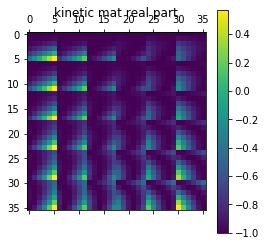

<Figure size 432x288 with 0 Axes>

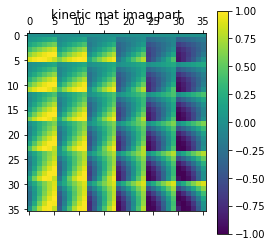

In [111]:
p = phase_matrix(6,6,B=1/36);
print('test phase matrix datatype:',)
plt.figure();plt.matshow(np.real(p));plt.colorbar();plt.title('kinetic mat real part');
plt.figure();plt.matshow(np.imag(p));plt.colorbar();plt.title('kinetic mat imag part');

test kinetic matrix with phase output datatype: complex128


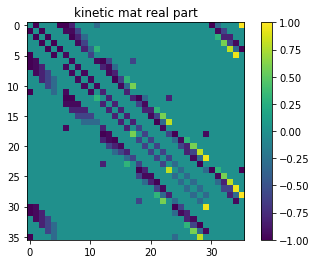

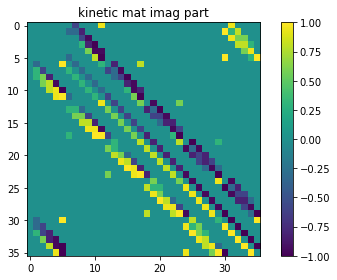

In [104]:
kay = makeKMatrix_with_phase(6,6,t=1,tp = 1,mu=0,B=0.1);
print('test kinetic matrix with phase output datatype:',kay.dtype)
plt.figure();plt.imshow(np.real(kay));plt.colorbar();plt.title('kinetic mat real part');
plt.figure();plt.imshow(np.imag(kay));plt.colorbar();plt.title('kinetic mat imag part');
plt.tight_layout();

## Exp(V) terms arising from U != 0

In [7]:
def makeExpLamSData(S,spin):
    '''Construct the length N vector exp(spin*lmbd*S[:,l]) for every single l = 0...L-1.
    Each length N vector stands for a diagonal matrix of size N-by-N. 
    There are L total such matrices.
    For efficiency, store information for all L matrices in one N-by-L 2D array.
    Each column represents a different diagonal matrix expV
    
    Args:
        S = (N,L) int np array, current H-S field configuration
        spin = 1 or -1, representing up or down spin
    
    Returns:t
        (N,L) np array storing exp(V(l,spin)) data
    '''
    
    assert spin == 1 or spin == -1, "Spin value must be +1 or -1"
    
    diags = np.zeros((N,L),dtype=float);
    for l in range(L):
        diags[:,l] = np.exp(lmbd*S[:,l]*spin);
        
    return diags

## Equal time Green's function 

In [8]:
def makeGMatrix_QR(expVData,l_shift=0,batch_size=10,check=False):
    '''Calculate equal-time GF from scratch using Pivoted-QR to avoid 
    numerical error accumulation. Method described in tutorial.
    
    Args:
        expVData: N-by-L 2D array, V matrix data (depends on current H-S config).
                  Each column is exp(spin*lmbd*S[:,l]).
        l_shift: Account for change in GF defn after l wraps. 
                 Defaults to 0, no wrapping
        batch_size: Number of B matrices to directly multiply together. 
                    Defaults to 10, a typical safe value
        check: bool, whether to check if batch_size is safe. 
               Defaults to False in simulation
        
    Returns:
        A (N,N) np-array, equal-time GF matrix
        A complex number, representing sign/phase of determinant of this GF matrix
    '''
    
    #dimensions
    N,L = expVData.shape
    
    #account for l_shift wraps: Roll forward, so that we start with 
    # the l-th column in zero-th column
    expVData = np.roll(expVData,-l_shift,axis=1)

    #divide into batches to reduce number of QR decomps we have to do
    num_batches = L//batch_size
    Bmats = [];
    #form every batch by normal matrix multiplication
    for j in range(num_batches):   
        #split along axis 1 (L-axis) into batches
        data_j = expVData[:,j*batch_size:(j+1)*batch_size]
        #start with identity
        Bmat = np.identity(N, dtype=complex)
        #form B[(j+1)*b]....B[j*b] by multiplying right to left
        for l in range(data_j.shape[1]):
            Bmat = (invexpdtK*data_j[:,l]) @ Bmat
        Bmats.append(Bmat)
    #if no even split, then one extra batch with fewer matrices
    if L % batch_size != 0:
        data_j = expVData[:,(num_batches*batch_size):]
        Bmat = np.identity(N, dtype=complex)
        for l in range(data_j.shape[1]):
            Bmat = (invexpdtK*data_j[:,l]) @ Bmat
        Bmats.append(Bmat)
        num_batches += 1 #account for extra batch
    
    #Now, go through Bmats and calculate matrix products 
    Q,R,perm = la.qr(Bmats[0],pivoting=True)
    inv_perm = np.argsort(perm) #inverse of permutation: P^{-1} = P^T.
    D_arr = np.diagonal(R) #extract diagonal
    T = 1/D_arr[:,None] * R[:,inv_perm] #T = inv(D) @ R @ P^T

    for l in range(1,num_batches):
        #l-th B matrix batch
        C = Bmats[l] @ Q * D_arr
        Q,R,perm = la.qr(C,pivoting=True)
        inv_perm = np.argsort(perm)
        D_arr = np.diagonal(R)
        T = ((1/D_arr[:,None]) * R[:,inv_perm]) @ T
        #assert (Q * D_arr) @ T == Bmats[l]...Bmats[0]
    
    #post processing        
    #elementwise product, Db*Ds = D
    Db_arr = np.zeros(D_arr.shape,dtype=complex)
    Ds_arr = np.zeros(D_arr.shape,dtype=complex)
    for i in range(N):
        if np.abs(D_arr[i]) > 1:
            Db_arr[i] = D_arr[i]
            Ds_arr[i] = 1
        else:
            Db_arr[i] = 1
            Ds_arr[i] = D_arr[i]
            
    #result  
    g = la.solve(1/Db_arr[:,None] * Q.conj().T + Ds_arr[:,None]*T,\
                 1/Db_arr[:,None] * Q.conj().T)
    
    
    #TODO: correctly handle complex case for this whole function?
    #det(Db)/|det(Db)|
    Db_sign = np.prod(np.sign(Db_arr))
    #det(stuff)/|det(stuff)|
    extra = la.solve(Q,1/Db_arr[:,None] * Q.conj().T + Ds_arr[:,None]*T)
    detextra = np.linalg.det(extra)
    sign = Db_sign*detextra/np.abs(detextra)
    #sign2,_ = np.linalg.slogdet(g)
    #if sign != sign2:
        #print(sign,sign2)
    
    
    '''check == False for simulations, only for experiment'''
    if check:
        print("checking if batch size",batch_size,"is safe")
        #start with B_0
        Bmat_0 = invexpdtK*expVData[:,0]
        Q,R,perm = la.qr(Bmat_0,pivoting=True)
        inv_perm = np.argsort(perm) 
        D_arr = np.diagonal(R)
        T = 1/D_arr[:,None] * R[:,inv_perm] #T = inv(D) @ R @ P^T
        
        #Matrix products via QR trick
        for l in range(1,L):
            #l-th B matrix
            Bmat_l = invexpdtK*expVData[:,l]
            C = Bmat_l @ Q * D_arr
            Q,R,perm = la.qr(C,pivoting=True)
            inv_perm = np.argsort(perm)
            D_arr = np.diagonal(R)
            T = ((1/D_arr[:,None]) * R[:,inv_perm]) @ T
            
        #post processing 
        Db_arr = np.zeros(D_arr.shape,dtype=complex)
        Ds_arr = np.zeros(D_arr.shape,dtype=complex)
        for i in range(N):
            if np.abs(D_arr[i]) > 1:
                Db_arr[i] = D_arr[i]
                Ds_arr[i] = 1
            else:
                Db_arr[i] = 1
                Ds_arr[i] = D_arr[i]
            
        #check result
        g_check = la.solve(1/Db_arr[:,None] * Q.conj().T + Ds_arr[:,None]*T,\
                 1/Db_arr[:,None] * Q.conj().T)
        
        print("deviation from when every B matrix is factored =",la.norm(g-g_check))
        if la.norm(g-g_check) > 1e-8:
            raise RuntimeError(f'QR batch size for GF calculation is unsafe, la.norm(g-g_check) = {la.norm(g-g_check) }')
    
    return g,sign

In [9]:
def half_wrap(G):
    '''Produce symmetric Trotter decomp version of GF from asymmetric version
    
    Args:
        G, unwrapped GF matrix used in simulation?? TODO: check we can use unwrapped GF
        for everything else and just do wrapping before measurement. YES
        TODO: how much overhead do these functions add? Make them inline
        
    Returns:
        (N,N) np array, wrapped GF matrix'''
    return expdt_halfK @ G @ invexpdt_halfK

In [10]:
g_QR,sign_QR = makeGMatrix_QR(expVdData,l_shift = 0,batch_size = 10,check=True)
print('sign = ',sign_QR)
plt.figure();plt.imshow(g_QR.real);plt.colorbar();
plt.figure();plt.imshow(g_QR.imag);plt.colorbar();

NameError: name 'expVdData' is not defined

## Unequal time Green's function

### BSOFI Algorithm

In [11]:
def Visualize(mat,name):
    assert np.iscomplexobj(mat)
    plt.figure(figsize=(10,4));
    plt.subplot(1,2,1);
    plt.imshow(mat.real);plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"{name} mat L*N = {L*N} real")
    plt.subplot(1,2,2);
    plt.imshow(mat.imag);plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"{name} mat L*N = {L*N} imag")
    plt.tight_layout();

In [12]:
def Make_B_List(expVData):
    '''Make list of off-diagonal matrices in matrix O. deriv. Eq. (20)
    
    Args:
        expVData, (N,L) matrix, each column reps a (N,N) diagonal mat
        
    Returns:
        python list of (N,N) matrices.'''
    
    _,L = expVData.shape
    B_list = [];
    for j in range(L):
        Bmat = invexpdtK*expVData[:,j]
        #note negative signs, except for bdy term B_{L-1}
        if j == L - 1:
            B_list.append(Bmat)
        else:
            B_list.append(-Bmat)
            
    return B_list

In [13]:
def Show_P_Cyclic_Full(B_list):
    '''Given list of B matrices, make and plot the full (NL,NL) dimensional
    normalized block p-cyclic matrix O.
    
    Args:
        B_list: length L list of sub-diagonal and boundary blocks of p-cyclic matrix
        
    Returns:
        O_mat: (NL,NL) np array'''
    
    L = len(B_list); N,N = B_list[0].shape;
    O_mat = np.zeros((N*L,N*L),dtype=complex)
    
    for i in range(L):
        #diagonal: all identity
        O_mat[i*N:(i+1)*N,i*N:(i+1)*N] = np.identity(N,dtype=complex)
        if i == L-1: #special boundary term
            O_mat[0:N,i*N:(i+1)*N] = B_list[i]
        else: #-1 diagonal
            O_mat[(i+1)*N:(i+2)*N,i*N:(i+1)*N] = B_list[i]
    
    Visualize(O_mat,'O')
    
    return O_mat

In [14]:
def Get_R_Full(R_dict,N,L):
    '''Given dictionary of R entries, create full (NL,NL) R matrix, which 
    has block upper bidiagonal form with an extra last block column
    
    Args:
        R_dict: size (3L-3) dictionary of R matrix block entries.
                key = tuple of entry coordinates
                value = (N,N) np array
                
    Returns:
        R_full: (NL,NL) upper triangular np array'''
    R_full = np.zeros((N*L,N*L),dtype=complex)
    for k,v in R_dict.items():
        i = k[0]; j = k[1];
        R_full[i*N:(i+1)*N,j*N:(j+1)*N] = v
    
    return R_full

In [15]:
def Show_R_Full(R_dict,N,L):
    '''Given dictionary of R entries, create and show full (NL,NL) R matrix, which 
    has block upper bidiagonal form with an extra last block column
    
    Args:
        R_dict: size (3L-3) dictionary of R matrix block entries.
                key = tuple of entry coordinates
                value = (N,N) np array
                
    Returns:
        R_full: (NL,NL) upper triangular np array'''
    R_full = np.zeros((N*L,N*L),dtype=complex)
    for k,v in R_dict.items():
        i = k[0]; j = k[1];
        R_full[i*N:(i+1)*N,j*N:(j+1)*N] = v
    
    Visualize(R_full,'R')
    
    return R_full

In [16]:
def Show_Q_Full(Q_list,N,L):
    '''Given list of Q (2N,2N) matrices, create and show full (NL,NL) Q matrix
        
    Args:
        Q_list, length L-1 list of (2N,2N) orthogonal matrices
        
    Returns:
        Q_full: (NL,NL) orthogonal matrix'''
    
    Q_full = np.identity(N*L,dtype=complex)
    
    for k in range(len(Q_list)):
        pad = np.eye(N*L,dtype=complex)
        pad[k*N:(k+2)*N,k*N:(k+2)*N] = Q_list[k]
        Q_full = Q_full @ pad #Q0 @ Q1 @ ... @ Q(L-2)
    
    Visualize(Q_full,'Q')
        
    return Q_full

In [17]:
def Show_Q_Inv_Full(Q_list,N,L):
    '''Given list of Q (2N,2N) matrices, create and show full (NL,NL) Q matrix
        
    Args:
        Q_list, length L-1 list of (2N,2N) orthogonal matrices
        
    Returns:
        Q_inv_full: (NL,NL) orthogonal matrix'''
    Q_inv_full = np.identity(N*L,dtype=complex)
    for k in range(len(Q_list)):
        pad = np.eye(N*L,dtype=complex)
        pad[k*N:(k+2)*N,k*N:(k+2)*N] = Q_list[k]
        Q_inv_full = pad.conj().T @ Q_inv_full #not sure about mulciplication order
    
    Visualize(Q_inv_full,'Inv Q')
        
    return Q_inv_full

In [18]:
def Block_Struct_Orth_Fact(B_list):
    '''Block structured orthogonal factorization (BSOF), a block structured QR
    factorization algorithm introduced in Wright, S.J., 1992.
    Args:
        B_list: length L list of sub-diagonal and boundary blocks of p-cyclic matrix
        
    Returns:
        Q_list, length L-1 list of (2N,2N) orthogonal matrices
        R_dict, size (3L-3) dictionary of R matrix block entries.
                key = tuple of entry coordinates
                value = (N,N) np array
    
    TODO: Better return structure for R
          Set to 0 the very small elements of Q and R?
    ''' 
    #input shapes
    L = len(B_list); N,N = B_list[0].shape;
    
    #output accumulators
    Q_list=[];
    R_dict = {};
    
    #initial step
    tempA = np.identity(N,dtype=complex);
    tempB = B_list[-1]
    #first L-2 blocks
    for k in range(L-2):
        #compute QR, set R diagonal element
        tall_mat = np.concatenate((tempA, B_list[k]), axis=0)
        Q,R = la.qr(tall_mat);
        #plt.figure();plt.imshow(R);plt.colorbar()
        Q_list.append(Q)
        R_dict[(k,k)] = R[:N,:N] #take top part only
        #update tempA,tempB, set off diagonal R elements
        rhs = np.zeros((2*N,2*N),dtype=complex);
        #####rhs[N:,:N] = A_list[k+1]; rhs[:N,N:] = tempB;
        rhs[N:,:N] = np.identity(N,dtype=complex); rhs[:N,N:] = tempB;
        lhs = Q.conj().T @ rhs
        tempA = lhs[N:,:N]
        tempB = lhs[N:,N:]
        R_dict[(k,k+1)] = lhs[:N,:N]
        R_dict[(k,L-1)] = lhs[:N,N:]
    #last QR block
    rhs_row1 = np.concatenate((tempA, tempB), axis=1)
    #####rhs_row2 = np.concatenate((B_list[-2], A_list[-1]), axis=1)
    rhs_row2 = np.concatenate((B_list[-2], np.identity(N,dtype=complex)), axis=1)
    rhs = np.concatenate((rhs_row1, rhs_row2), axis=0)
    Q,R = la.qr(rhs)
    R_dict[(L-2,L-2)] = R[:N,:N];
    R_dict[(L-2,L-1)] = R[:N,N:];
    R_dict[(L-1,L-1)] = R[N:,N:]
    Q_list.append(Q)

    #check output shapes
    assert len(Q_list) == L-1 and len(R_dict) == 3*L-3
    
    return Q_list,R_dict

In [19]:
def Invert_R_Row_BBS(R,N,L):
    '''Get X = R^{-1} based on RX = I using Row Block Back Substitution.
    Not exactly same as paper description.
    
    Args:
        R: Full R matrix (NL,NL)
        N: Size of each block
        L: Number of blocks
        
    Returns:
        X = full R inverse, (NL,NL)
    '''
    X = np.zeros((L*N,L*N),dtype=complex)
    #last (3N,3N) block is full, directly solve
    X[(L-3)*N:,(L-3)*N:] = \
        la.solve_triangular(R[(L-3)*N:,(L-3)*N:],np.identity(3*N))
    #Row block back substitution
    for i in range(L-3):
        #print(f"row {i}")
        #remaining diagonal (i,i) block shape (N,N)
        X[i*N:(i+1)*N,i*N:(i+1)*N] = \
            la.solve_triangular(R[i*N:(i+1)*N,i*N:(i+1)*N],np.identity(N))
    
    #last block column, incomplete RHS
    X[:(L-3)*N,(L-1)*N:] = \
        -R[:(L-3)*N,(L-1)*N:] @ X[(L-1)*N:,(L-1)*N:]
    for i in range(L-4,-1,-1):
        #print(f"modify row {i} in place")
        #complete rhs
        X[i*N:(i+1)*N,(i+1)*N:] -= \
            R[i*N:(i+1)*N,(i+1)*N:(i+2)*N] @ X[(i+1)*N:(i+2)*N,(i+1)*N:]
        #solve using X[i,i] = Rinv[i,i]
        X[i*N:(i+1)*N,(i+1)*N:] = \
            X[i*N:(i+1)*N , i*N:(i+1)*N] @ X[i*N:(i+1)*N,(i+1)*N:].copy()
    return X

In [20]:
def Apply_Orth_Fact(Rinv,Q_list,N,L):
    '''Produce R^{-1} @ Q^T, inverse of full p-cyclic matrix.
    Apply Q to pairs of columns of R^{-1}, back to front.
    TODO: use paper trick to reduce flops
    
    Args:
        Rinv, start with full R^{-1}, modified in place, end at R^{-1} @ Q^T
        Q_list, length L-1 list of (2N,2N) orthogonal matrices
        N: Size of each block
        L: Number of blocks
        
    Returns:
        None
    
    '''
    for k in range(L-2,-1,-1):
        Rinv[:,k*N:(k+2)*N] = Rinv[:,k*N:(k+2)*N] @ Q_list[k].conj().T
    return None

### Test BSOFI on small problem

In [21]:
Gu_list = Make_B_List(expVuData)
qlist, rdict = Block_Struct_Orth_Fact(Gu_list)

qfull = Show_Q_Full(qlist,N,L)
qinvfull = Show_Q_Inv_Full(qlist,N,L)

#Visualize(qfull.conj().T-qinvfull,"Q.conj.T - Q^{-1}")

rfull = Show_R_Full(rdict,N,L)
ofull = Show_P_Cyclic_Full(Gu_list)
Visualize(qfull @ rfull, "Recon O")

#Visualize(qfull @ rfull - ofull,"Q@R-O")

xfull = Invert_R_Row_BBS(rfull,N,L)
Visualize(xfull,"inv R")

Apply_Orth_Fact(xfull,qlist,N,L)
Visualize(xfull,"R^{-1}Q^H")

Visualize(xfull @ ofull,"R^{-1}Q^H @ O")

NameError: name 'expVuData' is not defined

In [22]:
def Get_Full_O_Inv(expVData):
    '''Get full O^{-1} which gives all unequal time GFs
    
    Args:
        expVData: (N,L) matrix, each col reps a diagonal mat
        
    Returns:
        (NL,NL) mat, full O^{-1}'''
    N,L = expVData.shape
    blist = Make_B_List(expVData)
    #Block structured orthogonal factorization (BSOF)
    qlist, rdict = Block_Struct_Orth_Fact(blist)
    #X = R^{-1}
    rfull = Get_R_Full(rdict,N,L)
    xfull = Invert_R_Row_BBS(rfull,N,L)
    #Apply Q^T to get O^{-1} = R^{-1} @ Q^T, X modified in place
    Apply_Orth_Fact(xfull,qlist,N,L)
    
    return xfull

### Translational Symmetry Compression

In [23]:
def ij_pairs_list(Nx,Ny,dx,dy):
    '''Produce Gblock indices (ilist,jlist) for fixed hopping distance vector (site_j-site_i)
    
    Args:
        Nx, Ny: dimension of lattice
        dx, dy: desired hopping direction vector
    Out:
        A tuple of lists (ilist, jlist) representing row and column indices
        of N*N Gblock matrix we want to extract
    '''
    ilist,jlist = [],[]
    
    #starting location (x,y)
    for y in range(Ny):
        for x in range(Nx):
            n_init = x+Nx*y
            #termination location (x+dx,y+dy) periodic BC
            pt_end = ((x+dx) % Nx,(y+dy) % Ny)
            n_end = pt_end[0]+Nx*pt_end[1]
            ilist.append(n_init);
            jlist.append(n_end);
    return ilist,jlist

In [24]:
def Make_Vec_To_IJ_Dict(Nx,Ny):
    '''Make lookup table/dictionary mapping distance (dx,dy) to lists of 
    total i,j indices in Gblock matrix separated by distance (dx,dy)
    Args:
        Nx, Ny: dimension of lattice
    Out:
        A nested dictionary, [dx][dy]-th entry is a tuple of lists
            (ilist, jlist) representing row and column indices of N*N 
            Gblock matrix that are separated by same distance (dx,dy). 
            Each list is length N '''
    table = {}
    for dx in range(Nx):
        table[dx] = {}
        for dy in range(Ny):
            indices = ij_pairs_list(Nx,Ny,dx,dy)
            table[dx][dy] = indices
            
    return table

In [25]:
def Make_IJ_To_Vec_Dict(Nx,Ny):
    '''Make lookup table/dictionary, mapping total index of Gblock[i][j] to 
    site_j-site_i distance tuple (dx,dy). This is a many to 1 mapping, 
    N (i,j) pairs will map to same (dx,dy) tuple
    Args:
        Nx, Ny: dimension of lattice
    Out:
        A nested dictionary, [i][j]-th entry is a tuple (dx,dy) representing 
        spatial distance vector (site_j - site_i) considering periodic wrapping'''
    table = {}
    for i in range(N):
        table[i] = {}
        for j in range(N):
            ix = i % Nx; iy = i // Nx;
            jx = j % Nx; jy = j // Nx;
            table[i][j] = ((jx-ix) % Nx, (jy-iy) % Ny)
            
    return table

In [26]:
def Trans_Symm_Compress(vec2ij_dict,Gt0s):
    '''Apply translational symmetry: G(pt_i,pt_j) = G(pt_j-pt_i). Average over elements with 
    same spatial separation in raw Gt0 measurements to get compressed measurement values
    Input:
        (L,N,N) np-array representing first block column of O^{-1}. Usually outout of Get_Gt0s
    Returns:
        (L,Nx,Ny) np-array: compressd measurements, each page is F ordered to represent G[]'''
    assert Gt0s.shape[1] == Gt0s.shape[2] and Gt0s.shape[1] == Nx*Ny
    L , N, _ = Gt0s.shape;
    #initialize compressed measurement
    compressed = np.zeros((L,Nx,Ny),dtype=complex)
    for dx in range(Nx):
        for dy in range(Ny):
            #avoid recomputing neighbor indices....
            indices = vec2ij_dict[dx][dy]
            for l in range(L):
                #n = dx+Nx*dy
                compressed[l,dx,dy]= np.mean(Gt0s[l,indices[0],indices[1]])
                
    #if compressing equal time correlator, then remove extra dim to return (Nx,Ny) 2D array
    return np.squeeze(compressed)

In [27]:
def Bond_Type_Dir(bps):
    '''Dictionary of bond type number -> hopping distance. Differs from Edwin's diagonal bond defs!!
    Args:
        bps = 2 or 4, number of bond types
    Returns:
        A dictionary mapping integers 0...bps to direction tuples'''
    btmap = [];
    btmap.append((1,0)); #[0] along x, vert
    btmap.append((0,1)); #[1] along y, horiz
    if bps == 4:
        btmap.append((1,1));#[2] diag
        btmap.append((-1,1)); #[3] another diag
    if bps != 2 and bps != 4:
        raise RuntimeError("invalid bps")
    return btmap

In [28]:
def Delta_Mask_Dict(btmap,plot = False):
    '''Produce delta function masks used for bond-bond correlation measurements
    Args:
        btmap: dictionary mapping integers 0...bps to direction tuples
    Returns:
        A nested dictionary, entry [(itype,mtype)][dname] where dname = 'im','in','jm','jn' 
        is (N,N) array, zero except for locations where dname[0] == dname[1]
    
    '''
    #set up nested dictionary structure
    dmdict = {}
    for itype in range(bps):
        for mtype in range(bps):
            dmdict[(itype,mtype)] = {}
    
    for itype in range(bps):
        idx,idy = btmap[itype];
        ilist,jlist = vec2ij_dict[idx % Nx][idy % Ny] #account for possible wrapping
        for mtype in range(bps):
            mdx,mdy = btmap[mtype];
            mlist,nlist = vec2ij_dict[mdx % Nx][mdy % Ny] #account for possible wrapping
            #build nontrivial masks
            delta_in = np.zeros((N,N))
            delta_jm = np.zeros((N,N))
            delta_jn = np.zeros((N,N))
            #look at every (i,m bond pair)
            for i in ilist:
                j = jlist[i] 
                for m in mlist:
                    n = nlist[m]
                    if i == n : delta_in[i,m] = 1
                    if j == n : delta_jn[i,m] = 1
                    if j == m : delta_jm[i,m] = 1
            
            dmdict[(itype,mtype)]['im'] = np.identity(N)
            dmdict[(itype,mtype)]['in'] = delta_in
            dmdict[(itype,mtype)]['jm'] = delta_jm 
            dmdict[(itype,mtype)]['jn'] = delta_jn 
    
    if plot == True:
        for itype in range(bps):
            for mtype in range(bps):
                corr = 'jn'
                plt.figure();
                plt.imshow(dmdict[(itype,mtype)][corr]);plt.colorbar()
                plt.title(f"{itype,mtype},{corr}");
    
    return dmdict

In [29]:
def permute_col(plist,G):
    '''convenience function for bond-bond measurement
    TODO: how much overhead do these functions add? Make them inline'''
    return G[:,plist]

In [30]:
def permute_row(plist,G):
    '''convenience function for bond-bond measurement Make them inline'''
    return G[plist,:]

# Run 1 Markov chain for 1 set of params

In [31]:
# Input Parameters
#lattice spacing  = 1
Nx = 4; #height of lattice
Ny = 4; #width of lattice
U = 4; #Coulomb interaction strength
t = 1; #NN hopping strength
tp = 0; #NNN hopping strength
mu = 0; #chemical potential
nflux = 1; #number of fundamentl flux quantum phi0 = h*c/e that crosses system

if tp != 0:
    bps = 4; #bonds per site, 2D square lattice with NNN
else:
    bps = 2; #bonds per site, 2D square lattice with NNN

beta = 1 #inverse temperature
L = np.maximum(5,np.ceil(beta/0.1),casting='unsafe',dtype=int) #number of time slices

n_sweep_warm = 200; #number of warm up Monte Carlo sweeps.
n_sweep_meas = 800; #number of measurement Monte Carlo sweeps.
period_eqlt = 5; #number of time slice wraps between equal time measurements
period_uneqlt = 8;#number of full sweeps between unequal time measurements
wrap_every = 8 #number of l-wraps between calculating GF from scratch
batch_size = 2*wrap_every #number of B matrices to directly multiply together

# Derived constants
N = Nx*Ny; #total number of grid points
dt = beta/L; #imaginary time interval
Bfield = nflux/N
print(f'Running Markov chain for {Nx}*{Ny} Lattice')
print(f'Interactions:U = {U}, t = {t}, t\' = {tp}, mu = {mu}, bps={bps}')
print('Temerature: beta = ',beta,', dt = ',dt,', L = ',L)
print("Recompute GF every",wrap_every,'l-wraps;',batch_size,'matmuls between QRs')
print("Measure eqlt every",period_eqlt,'l-wraps; measure uneqlt every',period_uneqlt,'full sweeps')
print(f"External B-field = {Bfield}, corresponds to {nflux} units of flux quantum")
lmbd = np.arccosh(np.exp(U*dt*0.5)) #lambda in H-S transform
kmatrix = makeKMatrix_with_phase(Nx,Ny,t=t,tp=tp,mu=mu,B=Bfield);
#Various exp(dtK) factors
invexpdtK = la.expm(-dt*kmatrix);
expdtK = la.expm(dt*kmatrix); #this matrix used only in G-fun wrapping
invexpdt_halfK = la.expm(-0.5*dt*kmatrix); #symmetric Trotter half wrap only before measurmeent
expdt_halfK = la.expm(0.5*dt*kmatrix); #symmetric Trotter half wrap only before measurement


#Initialize Auxillary H-S field as N-by-L 2D array.
#Each column is a different time slice
S = np.random.choice([-1,1],(N,L))
expVuData = makeExpLamSData(S,spin=1);
expVdData = makeExpLamSData(S,spin=-1);
Gu,_ = makeGMatrix_QR(expVuData,0,batch_size)
Gd,_ = makeGMatrix_QR(expVdData,0,batch_size)

params = {'Nx' : Nx,
          'Ny' : Ny,
          'N': N,
          'U': U,
          't' : t,
          'tp' : tp,
          'mu' : mu,
          'beta' : beta,
          'L' : L,
          'dt' : dt,
          'nflux': nflux,
          'B' : Bfield,
          'lmbd' : lmbd,
          'bps' : bps,
          'n_sweep_warm' : n_sweep_warm ,
          'n_sweep_meas' : n_sweep_meas,
          'period_eqlt' : period_eqlt, 
          'period_uneqlt' : period_uneqlt, 
          'wrap_every' : wrap_every, 
          'batch_size' : batch_size 
         }

#measurement accumulators
eqlt_data = {'n_sample' : np.zeros(1,dtype=int),
             'sign' : np.zeros(1,dtype=complex),
             'density' : np.zeros(1,dtype=complex),
             'double_occ' : np.zeros(1,dtype=complex),
             'zz' : np.zeros((N,N),dtype=complex), #before compression, z spin correlator
             'xx' : np.zeros((N,N),dtype=complex), #before compression, x or y spin correlator: they are exactly equivalent
             'nn': np.zeros((N,N),dtype=complex),  #before compression, charge correlator
             'pair_sw' : np.zeros((N,N),dtype=complex), #before compression, spin wave correlator
             'g00': np.zeros((N,N),dtype=complex)  #before compression, equal time GF
            }
uneqlt_data = {'n_sample' : np.zeros(1,dtype=int), 
               'sign' : np.zeros(1,dtype=complex),
               'gt0' : np.zeros((L*N,N),dtype=complex),#before compression, unequal time GF
               "zz" : np.zeros((L,N,N),dtype=complex), #before compression, z spin correlator
               "xx" : np.zeros((L,N,N),dtype=complex), #before compression, x or y spin correlator: they are exactly equivalent
               "nn" : np.zeros((L,N,N),dtype=complex), #before compression, charge correlator
               "pair_sw" : np.zeros((L,N,N),dtype=complex), #before compression, spin wave correlator
               "pair_bb" : np.zeros((L,bps,bps,N,N),dtype=complex), #before compression, pair (bond bond) correlator
               'jj' : np.zeros((L,bps,bps,N,N),dtype=complex), #before compression, current correlator
               'jsjs' : np.zeros((L,bps,bps,N,N),dtype=complex) #before compression, spin current correlator
              }

#lookup table to avoid recomputing neighbor indices
vec2ij_dict = Make_Vec_To_IJ_Dict(Nx,Ny)
btmap = Bond_Type_Dir(bps)
dmdict = Delta_Mask_Dict(btmap)

Running Markov chain for 4*4 Lattice
Interactions:U = 4, t = 1, t' = 0, mu = 0, bps=2
Temerature: beta =  1 , dt =  0.1 , L =  10
Recompute GF every 8 l-wraps; 16 matmuls between QRs
Measure eqlt every 5 l-wraps; measure uneqlt every 8 full sweeps
External B-field = 0.0625, corresponds to 1 units of flux quantum


In [32]:
#RUN MARKOV CHAIN
def run():
    for n in range(n_sweep_meas+n_sweep_warm):
        # Monitor progress
        if n % 200 == 0:
            print('Sweep # ',n)

        '''only take unequal time measurements if period_uneqlt > 0'''
        if period_uneqlt > 0 and n >= n_sweep_warm and n % period_uneqlt == 0 :
            # Recompute G-Funs before taking measurements 
            Gu_00,sgn_up = makeGMatrix_QR(expVuData,l_shift = 0, batch_size=batch_size)
            Gd_00,sgn_dn = makeGMatrix_QR(expVdData,l_shift = 0, batch_size=batch_size)
            sgn = sgn_up*sgn_dn
            #TODO: check that this is OK way to get sign? O(N^3)
            #if sgn < 0:
            #    print('sign < 0', sgn_up,sgn_dn)
            #Gu_00 = half_wrap(Gu_00)
            #Gd_00 = half_wrap(Gd_00)

            #Full inverse of O matrix!
            full_Gu = Get_Full_O_Inv(expVuData)
            full_Gd = Get_Full_O_Inv(expVdData)

            #collection of unequal time GFs: first column of O^{-1}
            Gu_t0s = full_Gu[:,:N]
            Gd_t0s = full_Gd[:,:N]

            uneqlt_data['n_sample'] += 1
            uneqlt_data['sign'] += sgn
            uneqlt_data['gt0'] += 0.5*sgn*(Gu_t0s+Gd_t0s) #avg over spin up and dn domains

            #TODO: symmetrize half wrap
            #diagonal elements of GFs at block 00
            diff_00 = np.diagonal(Gu_00)-np.diagonal(Gd_00)
            sum_00 = np.diagonal(Gu_00)+np.diagonal(Gd_00)
            for t in range(L):
                delta_t0 = t == 0
                Gu_tt = full_Gu[t*N:(t+1)*N,t*N:(t+1)*N] #(t,t) block
                Gd_tt = full_Gd[t*N:(t+1)*N,t*N:(t+1)*N] 
                Gu_t0 = full_Gu[t*N:(t+1)*N,:N] #(t,0) block
                Gd_t0 = full_Gd[t*N:(t+1)*N,:N]
                Gu_0t = full_Gu[:N,t*N:(t+1)*N] #(0,t) block
                Gd_0t = full_Gd[:N,t*N:(t+1)*N]

                #two site correlators
                diff_tt = np.diagonal(Gu_tt)-np.diagonal(Gd_tt)
                sum_tt = np.diagonal(Gu_tt)+np.diagonal(Gd_tt)
                t1 = np.outer(diff_tt,diff_00)
                t1_charge = np.outer(2-sum_tt,2-sum_00)
                t2 = delta_t0*np.diag(sum_00) #only nonzero for t = 0, i = j
                t3 = Gu_0t.T * Gu_t0 + Gd_0t.T * Gd_t0
                t3_xx = Gu_0t.T * Gd_t0 + Gd_0t.T * Gu_t0
                uneqlt_data['zz'][t] += 0.25*sgn*(t1+(t2-t3))
                uneqlt_data['xx'][t] += 0.25*sgn*(t2-t3_xx)
                uneqlt_data['nn'][t] += sgn*(t1_charge+(t2-t3))
                uneqlt_data['pair_sw'][t] += sgn*(Gd_t0*Gu_t0)

                #pair (bond bond) correlator
                for itype in range(bps):
                    idx,idy = btmap[itype];
                    ilist,jlist = vec2ij_dict[idx % Nx][idy % Ny];
                    ijterm_jj = (Gu_tt - Gu_tt.T + Gd_tt - Gd_tt.T)[ilist,jlist] 
                    ijterm_jsjs = (Gu_tt - Gu_tt.T - Gd_tt + Gd_tt.T)[ilist,jlist]
                    for mtype in range(bps):
                        mdx,mdy = btmap[mtype];
                        mlist,nlist = vec2ij_dict[mdx % Nx][mdy % Ny]
                        #vectorized as much as possible, 
                        #so expressions become less readable
                        #key: G[sorted,unsorted] = permute cols
                        #     G[unsorted,sorted] = permute rows
                        uneqlt_data['pair_bb'][t,itype,mtype,:,:] += \
                        sgn*0.5*(permute_row(jlist,permute_col(nlist,Gd_t0)) * Gu_t0 +
                            permute_row(jlist,Gd_t0) * permute_col(nlist,Gu_t0) +
                            permute_col(nlist,Gd_t0) * permute_row(jlist,Gu_t0) +
                            Gd_t0 * permute_row(jlist,permute_col(nlist,Gu_t0)))
                        '''
                        for ii in ilist:
                            jj = jlist[ii]
                            for mm in mlist:
                                nn = nlist[mm]
                                uneqlt_data['pair_bb_test'][t,itype,mtype,ii,mm] += \
                                sgn*0.5*(Gd_t0[jj,nn]*Gu_t0[ii,mm]+Gd_t0[jj,mm]*Gu_t0[ii,nn]+
                                         Gd_t0[ii,nn]*Gu_t0[jj,mm]+Gd_t0[ii,mm]*Gu_t0[jj,nn])'''

                        ##(spin) current current correlator, not fully vectorized  
                        mnterm_jj = (Gu_00 - Gu_00.T + Gd_00 - Gd_00.T)[mlist,nlist]
                        mnterm_jsjs = (Gu_00 - Gu_00.T - Gd_00 + Gd_00.T)[mlist,nlist]
                        #outer product
                        uneqlt_data['jj'][t,itype,mtype] += sgn*(np.outer(ijterm_jj,mnterm_jj))
                        uneqlt_data['jsjs'][t,itype,mtype] += sgn*(np.outer(ijterm_jsjs,mnterm_jsjs))
                        #mixed product. In effort to vectorize, exprs less readable
                        corrterm1 = sgn*(-permute_col(nlist,Gu_0t.T)*permute_row(jlist,Gu_t0) \
                             -permute_col(nlist,Gd_0t.T)*permute_row(jlist,Gd_t0) \
                             +Gu_0t.T*permute_row(jlist,permute_col(nlist,Gu_t0)) \
                             +Gd_0t.T*permute_row(jlist,permute_col(nlist,Gd_t0)) \
                             +permute_row(jlist,permute_col(nlist,Gu_0t.T))*Gu_t0 \
                             +permute_row(jlist,permute_col(nlist,Gd_0t.T))*Gd_t0 \
                             -permute_row(jlist,Gu_0t.T)*permute_col(nlist,Gu_t0) \
                             -permute_row(jlist,Gd_0t.T)*permute_col(nlist,Gd_t0))
                        uneqlt_data['jj'][t,itype,mtype] += corrterm1
                        uneqlt_data['jsjs'][t,itype,mtype] += corrterm1
                        
                        #terms which only appear at t == 0
                        if delta_t0:
                            delta_im = dmdict[(itype,mtype)]['im']
                            delta_in = dmdict[(itype,mtype)]['in']
                            delta_jm = dmdict[(itype,mtype)]['jm']
                            delta_jn = dmdict[(itype,mtype)]['jn']

                            corrterm2 = sgn*(+delta_in*(permute_row(jlist,Gu_t0+Gd_t0)) \
                                 -delta_im*(permute_row(jlist,permute_col(nlist,Gu_t0+Gd_t0))) \
                                 -delta_jn*(Gu_t0+Gd_t0) \
                                 +delta_jm*(permute_col(nlist,Gu_t0+Gd_t0)) )
                            uneqlt_data['jj'][t,itype,mtype] += corrterm2
                            uneqlt_data['jsjs'][t,itype,mtype] += corrterm2

                        #slow iteration, check vectorization correct.
                        '''
                        for ii in ilist:
                            jj = jlist[ii]
                            for mm in mlist:
                                nn = nlist[mm]
                                #mixed product
                                uneqlt_data['jj_test'][t,itype,mtype,ii,mm] += \
                                sgn*(-(Gu_0t[nn,ii]*Gu_t0[jj,mm]+Gd_0t[nn,ii]*Gd_t0[jj,mm])
                                     +(Gu_0t[mm,ii]*Gu_t0[jj,nn]+Gd_0t[mm,ii]*Gd_t0[jj,nn])
                                     +(Gu_0t[nn,jj]*Gu_t0[ii,mm]+Gd_0t[nn,jj]*Gd_t0[ii,mm])
                                     -(Gu_0t[mm,jj]*Gu_t0[ii,nn]+Gd_0t[mm,jj]*Gd_t0[ii,nn]))
                                #outer product
                                uneqlt_data['jj_test'][t,itype,mtype,ii,mm] += \
                                sgn*((Gu_tt[ii,jj] - Gu_tt[jj,ii] + Gd_tt[ii,jj] - Gd_tt[jj,ii])
                                     *(Gu_00[mm,nn] - Gu_00[nn,mm] + Gd_00[mm,nn] - Gd_00[nn,mm]))
                                #term only appears if t = 0
                                if delta_t0:
                                    din = ii == nn;
                                    djn = jj == nn;
                                    djm = jj == mm;
                                    dim = ii == mm;
                                    uneqlt_data['jj_test'][t,itype,mtype,ii,mm] += \
                                    sgn*(+din*(Gu_t0[jj,mm]+Gd_t0[jj,mm])
                                         -dim*(Gu_t0[jj,nn]+Gd_t0[jj,nn])
                                         -djn*(Gu_t0[ii,mm]+Gd_t0[ii,mm])
                                         +djm*(Gu_t0[ii,nn]+Gd_t0[ii,nn]))
                                         '''

        for l in range(L):
            '''take equal time measurements more frequently than full sweeps'''
            if n >= n_sweep_warm and l % period_eqlt == 0:
                # Recompute G-Funs before taking measurements?
                #use l = 0 or current l?
                Gu_00,sgn_up = makeGMatrix_QR(expVuData,l_shift=0,batch_size=batch_size) #10% time
                Gd_00,sgn_dn = makeGMatrix_QR(expVdData,l_shift=0,batch_size=batch_size) #10% time
                Gu_00 = half_wrap(Gu_00)
                Gd_00 = half_wrap(Gd_00)
                #TODO: check that this is OK way to get sign? O(N^3)
                sgn = sgn_up*sgn_dn
                #if sgn < 0:
                #    print('sign < 0', sgn_up,sgn_dn)

                #bookkeeping
                eqlt_data['n_sample'] +=1
                eqlt_data['sign'] += sgn
                eqlt_data['g00'] += sgn*0.5*(Gu_00+Gd_00) #avg over spin up and dn domains

                #diagonal elements of GFs
                Gu_00_diag = np.diagonal(Gu_00)
                Gd_00_diag = np.diagonal(Gd_00)
                diag_sum = Gu_00_diag+Gd_00_diag
                diag_diff = Gu_00_diag-Gd_00_diag

                #single site measurements, vectorized
                #TODO assumed round off error while accumulating measurements is neglegible
                eqlt_data['density']  += sgn*np.mean(2- diag_sum);
                eqlt_data['double_occ'] += sgn*np.mean((1 - Gu_00_diag)*(1 - Gd_00_diag))

                #two site measurements. vectorized, acting on N*N matrix
                t1_zz = np.outer(diag_diff,diag_diff)
                t1_charge = np.outer(2-diag_sum,2-diag_sum)
                t3 = Gu_00.T * Gu_00 + Gd_00.T * Gd_00 #a mixed product
                t3_xx = Gu_00.T * Gd_00  + Gd_00.T * Gu_00 #another mixed product
                eqlt_data['zz'] += sgn*0.25*(t1_zz + (np.diag(diag_sum) - t3))
                eqlt_data['xx'] += sgn*0.25*(np.diag(diag_sum) - t3_xx)
                eqlt_data['nn'] += sgn*(t1_charge + (np.diag(diag_sum) - t3))
                eqlt_data['pair_sw'] += sgn*(Gu_00 * Gd_00)


            if l % wrap_every == 0:
                #recompute GFs from scratch, reduce roundoff err from wrapping
                #Don't need determinant here
                Gu,_ = makeGMatrix_QR(expVuData,l_shift=l,batch_size=batch_size,check=False) #10% time
                Gd,_ = makeGMatrix_QR(expVdData,l_shift=l,batch_size=batch_size,check=False) #10% time

            ''' Update: after maybe taking measurement, go through every [i,l] pair and propose 
            # flipping s[i,l]. Result: A S-field drawn with probability propto w'_s = |w_s|'''
            for i in range(N):
                #Implicitly propose flipping s[i,l], calculate accept ratio
                detu = 1 + (1-Gu[i,i])*(np.exp(-2*lmbd*S[i,l])-1);
                detd = 1 + (1-Gd[i,i])*(np.exp(2*lmbd*S[i,l])-1);
                alpha = detu*detd; 
                #if alpha<0:
                    #print("alpha<0",alpha)
                #phase = alpha/np.absolute(alpha)
                r = np.random.random();
                #Probability Min(1,abs(alpha)) of accepting flip 
                #If accept, update Gfuns, S[i,l], expVu[i,l],expVd[i,l]
                #If reject, do nothing, look at next entry of S
                if r <= np.absolute(alpha):
                    #Update G-funs using old s-field entries
                    #Note : have to copy arrays to avoid modifying G-Funs prematurely
                    col = Gu[:,i].copy(); col[i] = col[i]-1; #i-th column of (Gup - delta)
                    row = Gu[i,:].copy(); #ith row of Gup
                    #TODO: Delayed update increase performance? Eq. (23) has redundant zz
                    #10% time
                    mat = np.outer(col,row)
                    Gu = Gu + (np.exp(-2*lmbd*S[i,l])-1)*mat/detu; 

                    col = Gd[:,i].copy(); col[i] = col[i]-1; #i-th column of (Gdn - delta)
                    row = Gd[i,:].copy(); #ith row of Gdn
                    #TODO: Delayed update increase performance?
                    #10% time
                    mat = np.outer(col,row)
                    Gd = Gd + (np.exp(2*lmbd*S[i,l])-1)*mat/detd;

                    #Update S matrix
                    S[i,l] *= -1;

                    #Update [i,l] entry of ExpLamSData_up, ExpLamSData_dn
                    expVuData[i,l] = np.exp(lmbd*S[i,l]);
                    expVdData[i,l] = np.exp(-lmbd*S[i,l]);

            #After each l slice, wrap the B matrices.
            #We do this in order to continue using nice formulas that allow us to quickly
            #  calculate alpha and update G-funs.
            #After l runs through 0...L-1, G-fun returns to textbook form, 
            #  with some roundoff errors from wrapping.
            diag_u = expVuData[:,l];
            diag_d = expVdData[:,l]; # == inv(diag_up)

            Blu = invexpdtK * diag_u;
            invBlu = diag_d[:,None] * expdtK;
            Gu = Blu @ Gu @ invBlu;

            Bld = invexpdtK * diag_d;
            invBld = diag_u[:,None] * expdtK;
            Gd = Bld @ Gd @ invBld;

run()

Sweep #  0
Sweep #  200
Sweep #  400
Sweep #  600
Sweep #  800


In [37]:
#Compress by translational symmetry at the end. Edwin does it while the DQMC runs   
#When complex, don't have trans symm anymore?
eqlt_data['g00'] = Trans_Symm_Compress(vec2ij_dict,eqlt_data['g00'][None,:])
eqlt_data['zz'] = Trans_Symm_Compress(vec2ij_dict,eqlt_data['zz'][None,:])
eqlt_data['xx'] = Trans_Symm_Compress(vec2ij_dict,eqlt_data['xx'][None,:])
eqlt_data['nn'] = Trans_Symm_Compress(vec2ij_dict,eqlt_data['nn'][None,:])
eqlt_data['pair_sw'] = Trans_Symm_Compress(vec2ij_dict,eqlt_data['pair_sw'][None,:])

uneqlt_data['gt0'] = np.reshape(uneqlt_data['gt0'],(L,N,N),order='C')
uneqlt_data['gt0'] = Trans_Symm_Compress(vec2ij_dict,uneqlt_data['gt0'])

uneqlt_data['zz'] = Trans_Symm_Compress(vec2ij_dict,uneqlt_data['zz'])
uneqlt_data['xx'] = Trans_Symm_Compress(vec2ij_dict,uneqlt_data['xx'])
uneqlt_data['nn'] = Trans_Symm_Compress(vec2ij_dict,uneqlt_data['nn'])
uneqlt_data['pair_sw'] = Trans_Symm_Compress(vec2ij_dict,uneqlt_data['pair_sw'])
#compressing jj is slightly more involved, must iterate over bond types
temp = np.empty((L,bps,bps,Nx,Ny),dtype=complex)
temp2 = np.empty((L,bps,bps,Nx,Ny),dtype=complex)
temp3 = np.empty((L,bps,bps,Nx,Ny),dtype=complex)
for ib in range(bps):
    for mb in range(bps):
        temp[:,ib,mb,:] = Trans_Symm_Compress(vec2ij_dict,uneqlt_data['jj'][:,ib,mb,:])
        temp2[:,ib,mb,:] = Trans_Symm_Compress(vec2ij_dict,uneqlt_data['pair_bb'][:,ib,mb,:])
        temp3[:,ib,mb,:] = Trans_Symm_Compress(vec2ij_dict,uneqlt_data['jsjs'][:,ib,mb,:])
uneqlt_data['jj'] = temp
uneqlt_data['pair_bb'] = temp2
uneqlt_data['jsjs'] = temp3

## Look at measurements

In [38]:
def summarize(v_edwin,name,eqlt=True):
    if eqlt:
        print('eqlt', name ,"shape", v_edwin.shape,eqlt_data[name].shape,\
              'relative distance =',\
              la.norm(np.mean(v_edwin,axis=0)-eqlt_data[name])/la.norm(np.mean(v_edwin,axis=0)))
    else:
        print('uneqlt',name,"shape",v_edwin.shape,uneqlt_data[name].shape,\
              'relative distance =',\
              la.norm(np.mean(v_edwin,axis=0)-uneqlt_data[name])/la.norm(np.mean(v_edwin,axis=0)))

In [39]:
def plot_data(v_edwin,name,page=-1):
    plt.figure(figsize=(10,10))
    if page==-1: #equal time case
        edwn_avg = np.mean(v_edwin,axis=0)
        plt.subplot(2,3,1);
        plt.imshow(edwn_avg.real);plt.colorbar(fraction=0.046, pad=0.04);
        plt.title(f"edwin eqlt {name}")
        plt.ylabel('dx');plt.xlabel('dy');
        
        plt.subplot(2,3,2);
        plt.imshow((eqlt_data[name]).real);plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(f"eqlt diff real")
        plt.ylabel('dx');plt.xlabel('dy');
        
        plt.subplot(2,3,3)
        plt.imshow((v_edwin[0]-edwn_avg).real);plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("internal diff real")
        plt.ylabel('dx');plt.xlabel('dy');
        
        plt.subplot(2,3,4);
        plt.imshow(edwn_avg.imag);plt.colorbar(fraction=0.046, pad=0.04);
        plt.title(f"edwin eqlt {name}")
        plt.ylabel('dx');plt.xlabel('dy');
        
        plt.subplot(2,3,5);
        plt.imshow((eqlt_data[name]).imag);plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(f"eqlt diff imag")
        plt.ylabel('dx');plt.xlabel('dy');
        
        plt.subplot(2,3,6)
        plt.imshow((v_edwin[0]-edwn_avg).imag);plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("internal diff imag")
        plt.ylabel('dx');plt.xlabel('dy');
        
        
    else: #unequal time case
        raise NotImplementedError()
        
    plt.tight_layout()

In [40]:
def plot_bb(v_edwin,name,page,v = (0,0)):
    if v[0] >= bps or v[1] >= bps:
        raise RuntimeError("invalid correlation type")
    
    plt.figure(figsize=(10,24))
    
    plt.subplot(1,3,1)
    plt.imshow(np.mean(v_edwin,axis=0)[page,v[0],v[1]]);
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"edwin uneqlt {name}, t={page},{v}")
    plt.ylabel('dx');plt.xlabel('dy');
    
    plt.subplot(1,3,2)
    plt.imshow(uneqlt_data[name][page,v[0],v[1]]-np.mean(v_edwin,axis=0)[page,v[0],v[1]]);
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"difference, t={page},{v}")
    plt.ylabel('dx');plt.xlabel('dy');
    
    plt.subplot(1,3,3)
    plt.imshow(v_edwin[0,page,v[0],v[1]]-np.mean(v_edwin,axis=0)[page,v[0],v[1]]);
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"internal difference, t={page},{v}")
    plt.ylabel('dx');plt.xlabel('dy');
    
    plt.tight_layout()

In [41]:
def check_jk(edwin_sign,edwin_v,name,page=-1):
    '''Agnostic to how many data points I collect'''
    #my jk
    plt.figure(figsize=(10,24))
    if page == -1:
        my_v = eqlt_data[name]/eqlt_data['sign']
        err = np.zeros(eqlt_data[name].shape)
        my_v_err = np.stack((my_v,err))
        #edwin_v = np.reshape(edwin_v,(-1,N),order='F')
        edwin_v_err = util.jackknife(edwin_sign,edwin_v)
        #temp = np.empty((2,Nx,Ny))
        #temp[0] = np.reshape(edwin_v_err[0],(Nx,Ny),order='F')
        #temp[1] = np.reshape(edwin_v_err[1],(Nx,Ny),order='F')
        #edwin_v_err = temp
        #print(edwin_v_err.shape)

        error_ok = np.abs(my_v_err[0]-edwin_v_err[0]) < edwin_v_err[1]

        plt.subplot(1,3,1);
        plt.imshow(edwin_v_err[0]);plt.colorbar(fraction=0.046, pad=0.04);
        plt.title(f"edwin eqlt {name}")
        plt.ylabel('dx');plt.xlabel('dy');

        plt.subplot(1,3,2);
        plt.imshow(my_v_err[0]-edwin_v_err[0]);plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(f"difference")
        plt.ylabel('dx');plt.xlabel('dy');

        plt.subplot(1,3,3)
        plt.imshow(error_ok.astype(int));plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("error in JK error?")
        plt.ylabel('dx');plt.xlabel('dy');

    else:
        #THIS PART DOES NOT WORK CORRECTLY YET
        my_v = uneqlt_data[name]/uneqlt_data['sign']
        err = np.zeros(uneqlt_data[name].shape)
        my_v_err = np.stack((my_v,err))
        print(my_v_err.shape)
        #edwin_v = np.reshape(edwin_v,(-1,N),order='F')
        edwin_v_err = util.jackknife(edwin_sign,edwin_v)
        #temp = np.empty((2,Nx,Ny))
        #temp[0] = np.reshape(edwin_v_err[0],(Nx,Ny),order='F')
        #temp[1] = np.reshape(edwin_v_err[1],(Nx,Ny),order='F')
        #edwin_v_err = temp
        print(edwin_v_err.shape)

        error_ok = np.abs(my_v_err[0]-edwin_v_err[0]) < edwin_v_err[1]

        plt.subplot(1,3,1);
        plt.imshow(edwin_v_err[0]);plt.colorbar(fraction=0.046, pad=0.04);
        plt.title(f"edwin eqlt {name}")
        plt.ylabel('dx');plt.xlabel('dy');

        plt.subplot(1,3,2);
        plt.imshow(my_v_err[0]-edwin_v_err[0]);plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(f"difference")
        plt.ylabel('dx');plt.xlabel('dy');

        plt.subplot(1,3,3)
        plt.imshow(error_ok.astype(int));plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("error in JK error?")
        plt.ylabel('dx');plt.xlabel('dy');

    plt.tight_layout()

In [44]:
def compare(path):
    '''Load measurements from SHERLOCK DQMC runs and compare them to my simulation result'''
    degen_i, map_i, degen_ij, map_ij = util.load(path,'params/degen_i','params/map_i','params/degen_ij','params/map_ij')
    bonds,num_b,degen_bb, map_bb, degen_bs, map_bs = \
    util.load(path,'params/bonds','params/num_b','params/degen_bb','params/map_bb','params/degen_bs','params/map_bs')
    print(map_ij[0])
    
    n_sample_eqlt, sign_eqlt,density, double_occ, \
    g00,nn, xx, zz, pair_sw = util.load(path, 
                        "meas_eqlt/n_sample", 
                        "meas_eqlt/sign",
                        'meas_eqlt/density', 
                        "meas_eqlt/double_occ",
                        "meas_eqlt/g00",
                        'meas_eqlt/nn',
                        'meas_eqlt/xx',
                        'meas_eqlt/zz',
                        'meas_eqlt/pair_sw')
    n_sample_uneqlt, sign_uneqlt,\
    gt0, nn_uneqlt, xx_uneqlt, zz_uneqlt, pair_sw_uneqlt,\
    pair_bb,jj,jsjs = util.load(path,"meas_uneqlt/n_sample", 
                        "meas_uneqlt/sign",
                        "meas_uneqlt/gt0",
                        'meas_uneqlt/nn',
                        'meas_uneqlt/xx',
                        'meas_uneqlt/zz',
                        'meas_uneqlt/pair_sw',
                        'meas_uneqlt/pair_bb',
                        'meas_uneqlt/jj',
                        'meas_uneqlt/jsjs')
    #bonds[0] structure: maps bond start points to map end points. shape (2,bps*N)
    #first row: source pts 0....N-1, repeated bps times
    #second row: end pts, bond labels label = N*bond_type+bond_origin
    #each column is thus a bond (origin,end) pair
    
    #map_bb[0] structure:
    #index 0 : bond b label
    #index 1 : bond c label
    #returns : spacially compressed accumulator label = bps*N*btype + N*ctype + indexof(c0-b0)
    #as 1d array (C code) : map_bb[blabel+bps*N*clabel] = above rhs
    '''
    blabel = 1*int(N[0])+2;
    clabel = 1*int(N[0])+6;
    print(bonds[0].shape,"bond b pair",bonds[0,:,blabel],"bond c pair",bonds[0,:,clabel])
    print(map_bb[0].shape,map_bb[0,blabel,clabel])
    print(np.reshape(map_bb[0],(bps*int(N[0])*bps*int(N[0])),order='F')[blabel + clabel*bps*int(N[0])])'''
    
    print("============= EQUAL TIME COMPARE =======================================")
    g00 = np.reshape(g00,(-1,Nx,Ny),order='F')
    zz = np.reshape(zz,(-1,Nx,Ny),order='F')
    xx = np.reshape(xx,(-1,Nx,Ny),order='F')
    nn = np.reshape(nn,(-1,Nx,Ny),order='F')
    pair_sw = np.reshape(pair_sw,(-1,Nx,Ny),order='F')
    
    summarize(n_sample_eqlt,'n_sample',eqlt=True)
    summarize(sign_eqlt,'sign',eqlt=True)
    summarize(density,'density',eqlt=True)
    summarize(double_occ,'double_occ',eqlt=True)
    summarize(g00,'g00',eqlt=True)
    summarize(nn,'nn',eqlt=True)
    summarize(xx,'xx',eqlt=True)
    summarize(zz,'zz',eqlt=True)
    summarize(pair_sw,'pair_sw',eqlt=True)
    
    plot_data(g00,'g00',page=-1)
    
    print('============================EQUAL TIME JACKKNIFED RESULTS========================')
    print("MINE:","<sign> = ", util.jackknife(eqlt_data['n_sample'],eqlt_data['sign']),
          "<n> = ", util.jackknife(eqlt_data['sign'],eqlt_data['density']),
          '<d> = ',util.jackknife(eqlt_data['sign'],eqlt_data['double_occ']))
    f=lambda s, o1, o2: ((o1.T-2*o2.T)/s.T).T
    print("<M_z> = ",util.jackknife(eqlt_data['sign'],eqlt_data['density'],eqlt_data['double_occ'],f=f))
    
    print("EDWIN:","<sign> = ", util.jackknife(n_sample_eqlt,sign_eqlt),
          "<n> = ", util.jackknife(sign_eqlt,np.squeeze(density)),
          '<d> = ',util.jackknife(sign_eqlt,np.squeeze(double_occ)))
    f=lambda s, o1, o2: ((o1.T-2*o2.T)/s.T).T
    print("<M_z> = ",util.jackknife(sign_eqlt,density,double_occ,f=f))
    

    
    '''
    print("============= UNEQUAL TIME COMPARE =======================================")
    #Edwin measurement accumulator is Fortran ordered 1D array
    #LSD -> MSD = [(j-i) gindex],jtype,itype,time
    #My measurement accumulator:
    #LSD -> MSD = (time,itype,jtype,[dx,dy of (j-i)])
    #Need to reshape and exchange axes of edwin to match my measurement shape
    gt0 = np.reshape(gt0,(-1,int(Nx[0]),int(Ny[0]),int(L[0])),order='F')
    gt0 = np.transpose(gt0,(0,3,1,2))
    zz_uneqlt = np.reshape(zz_uneqlt,(-1,int(Nx[0]),int(Ny[0]),int(L[0])),order='F')
    zz_uneqlt = np.transpose(zz_uneqlt,(0,3,1,2))
    xx_uneqlt = np.reshape(xx_uneqlt,(-1,int(Nx[0]),int(Ny[0]),int(L[0])),order='F')
    xx_uneqlt = np.transpose(xx_uneqlt,(0,3,1,2))
    pair_sw_uneqlt = np.reshape(pair_sw_uneqlt,(-1,int(Nx[0]),int(Ny[0]),int(L[0])),order='F')
    pair_sw_uneqlt = np.transpose(pair_sw_uneqlt,(0,3,1,2))
    nn_uneqlt = np.reshape(nn_uneqlt,(-1,int(Nx[0]),int(Ny[0]),int(L[0])),order='F')
    nn_uneqlt = np.transpose(nn_uneqlt,(0,3,1,2))

    jj = np.reshape(jj,(-1,int(Nx[0]),int(Ny[0]),bps,bps,int(L[0])),order='F')
    jj = np.transpose(jj,(0,5,4,3,1,2))
    jsjs = np.reshape(jsjs,(-1,int(Nx[0]),int(Ny[0]),bps,bps,int(L[0])),order='F')
    jsjs = np.transpose(jsjs,(0,5,4,3,1,2))
    pair_bb = np.reshape(pair_bb,(-1,int(Nx[0]),int(Ny[0]),bps,bps,int(L[0])),order='F')
    pair_bb = np.transpose(pair_bb,(0,5,4,3,1,2))
    
    summarize(gt0,'gt0',eqlt=False)
    summarize(n_sample_uneqlt,'n_sample',eqlt=False)
    summarize(sign_uneqlt,'sign',eqlt=False)
    summarize(nn_uneqlt,'nn',eqlt=False)
    summarize(xx_uneqlt,'xx',eqlt=False)
    summarize(zz_uneqlt,'zz',eqlt=False)
    summarize(pair_sw_uneqlt,'pair_sw',eqlt=False)
    
    
    #my defn of diagonal bonds differ from edwin, expect corr to differ
    summarize(jj,'jj',eqlt=False)
    print('non diagonal bonds relative distance =',\
          la.norm((np.mean(jj,axis=0)-uneqlt_data['jj'])[:,:2,:2,:,:])/la.norm(np.mean(jj,axis=0)[:,:2,:2,:,:]))
    summarize(pair_bb,'pair_bb',eqlt=False)
    print('non diagonal bonds relative distance =',\
          la.norm((np.mean(pair_bb,axis=0)-uneqlt_data['pair_bb'])[:,:2,:2,:,:])/la.norm(np.mean(pair_bb,axis=0)[:,:2,:2,:,:]))
    summarize(jsjs,'jsjs',eqlt=False)
    print('non diagonal bonds relative distance =',\
          la.norm((np.mean(jsjs,axis=0)-uneqlt_data['jsjs'])[:,:2,:2,:,:])/la.norm(np.mean(jsjs,axis=0)[:,:2,:2,:,:]))    

    #look at pages of compressed unequal time GF
    #very noisy around L/2
    page=1;v = (1,1)
    #check_jk(sign_uneqlt,gt0,'gt0',page)
    
    plot_data(zz_uneqlt,'zz',page)
    #plot_bb(pair_bb,'pair_bb',page,v)
    #plot_bb(jsjs,'jsjs',page,v)
    
    #FINAL RESULTS:
    
    #print("MINE: zz = ",(uneqlt_data['zz']/uneqlt_data['n_sample'])[0,1,1])
    #print("EDWIN:zz = ",util.jackknife(sign_uneqlt,zz_uneqlt)[0,0,1,1])
    #check_diff = uneqlt_data['zz']/uneqlt_data['n_sample'] - util.jackknife(sign_uneqlt,zz_uneqlt)[0]
    #plt.figure(); plt.imshow(check_diff[1]),plt.colorbar()'''

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 3  0  1  2  7  4  5  6 11  8  9 10 15 12 13 14]
 [ 2  3  0  1  6  7  4  5 10 11  8  9 14 15 12 13]
 [ 1  2  3  0  5  6  7  4  9 10 11  8 13 14 15 12]
 [12 13 14 15  0  1  2  3  4  5  6  7  8  9 10 11]
 [15 12 13 14  3  0  1  2  7  4  5  6 11  8  9 10]
 [14 15 12 13  2  3  0  1  6  7  4  5 10 11  8  9]
 [13 14 15 12  1  2  3  0  5  6  7  4  9 10 11  8]
 [ 8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7]
 [11  8  9 10 15 12 13 14  3  0  1  2  7  4  5  6]
 [10 11  8  9 14 15 12 13  2  3  0  1  6  7  4  5]
 [ 9 10 11  8 13 14 15 12  1  2  3  0  5  6  7  4]
 [ 4  5  6  7  8  9 10 11 12 13 14 15  0  1  2  3]
 [ 7  4  5  6 11  8  9 10 15 12 13 14  3  0  1  2]
 [ 6  7  4  5 10 11  8  9 14 15 12 13  2  3  0  1]
 [ 5  6  7  4  9 10 11  8 13 14 15 12  1  2  3  0]]
============= EQUAL TIME COMPARE =======================================
eqlt n_sample shape (5,) (1,) relative distance = 0.0
eqlt sign shape (5,) (1,) relative distance = 1.14442919

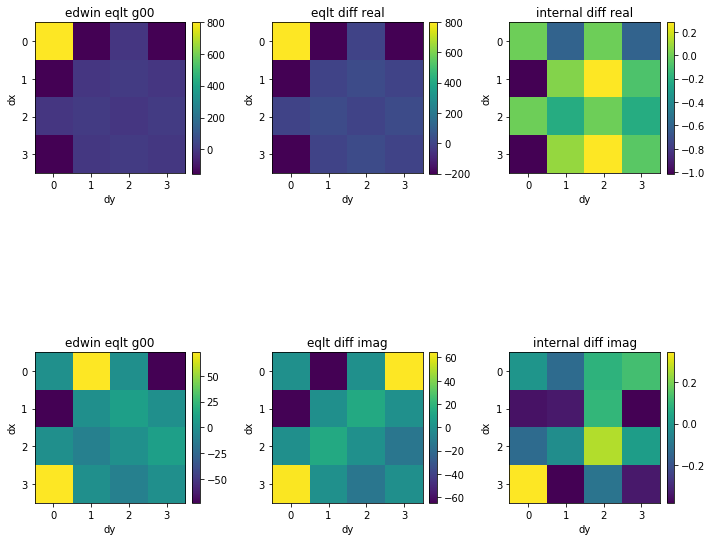

In [45]:
data_path = "../../Data-DQMC/test_complex/"
compare(data_path);

In [37]:
def print_my_data():
    #equal time
    print('---------equal time measurements----------')
    for k,v in eqlt_data.items():
        if len(v.shape) > 1:
            print(f"{k} shape = {v.shape}")
        else:
            print(f"{k}={v}, shape = {v.shape}")

    #unequal time
    print('---------unequal time measurements----------')
    for k,v in uneqlt_data.items():
        if len(v.shape) > 1:
            print(f"{k} shape = {v.shape}")
        else:
            print(f"{k}={v}, shape = {v.shape}")

In [38]:
print_my_data()

---------equal time measurements----------
n_sample=[1600], shape = (1,)
sign=[1600.], shape = (1,)
density=[1600.], shape = (1,)
double_occ=[219.847459], shape = (1,)
zz shape = (4, 4)
xx shape = (4, 4)
nn shape = (4, 4)
pair_sw shape = (4, 4)
g00 shape = (4, 4)
---------unequal time measurements----------
n_sample=[100], shape = (1,)
sign=[100.], shape = (1,)
gt0 shape = (10, 4, 4)
zz shape = (10, 4, 4)
xx shape = (10, 4, 4)
nn shape = (10, 4, 4)
pair_sw shape = (10, 4, 4)
pair_bb shape = (10, 2, 2, 4, 4)
jj shape = (10, 2, 2, 4, 4)
jsjs shape = (10, 2, 2, 4, 4)


In [ ]:
scipy